# Prediction of CO2 emissions from country-specific data

***

# Stage 3: Predictive data analysis with the varios machine learning algorithms

***

### Notebook Contents:

0. Introduction - project and notebook summaries, notes on the data source
1. Notebook setup - libraries and data import, dealing with randomness in the algorithms
2. Data overview
3. Used feature/column abbreviations
3. Hypothesis to be tested
4. Selection of dependent and independent variables
5. Dataset splitting into training and testing subsets
6. Feature selection with recursive feature elimination and cross-validation
7. Hyperparameter tuning
8. Train and evaluate the model with the best hyperparameters on the training data with cross-validation
9. Validate the model on the test subset (previously unseen data)
10. Conclusions

***

## 0. Introduction


The project is divided into three stages:

1. Data cleaning and preparation
2. Data exploration and visualization
3. Predictive analysis

Each of the stages is described in a separate Jupyter Notebook(.ipynb file) and a derived pdf file.

***

## Notebook summary - Stage 3: Predictive data analysis with the Random Forest machine learning algorithm

**Aim of this notebook**: This notebook will show the steps taken to develop a predictive Random Forest model by using the scikit-learn library. 

**Input**:
* csv data file produced by the script 1_data_exploration.py (output of Stage 1)
* trends and relationship insights gained during data visualization (output of Stage2)

**Output**:
* a predictive Random Forest model and its corresponding metrics by evaluating unseen data

**Programming language**: Python 3.8

**Libraries used in this notebook**: sklearn, numpy, pandas, seaborn, matplotlib, sys

***





In [73]:
# import all needed libraries
import pandas as pd
import numpy as np
import numpy.random as nr
import sys
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.model_selection as ms
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import feature_selection as fs

from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV


In [74]:
# load the cleaned dataset
data_cleaned = pd.read_csv(r'data_cleaned2.csv')

# load the pca dataset
data_pca = pd.read_csv(r'pca_result.csv')


In [75]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3360 entries, 0 to 3359
Data columns (total 32 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   country                             3360 non-null   object 
 1   year                                3360 non-null   int64  
 2   clean_fuel_access_perc              3360 non-null   float64
 3   elec_access_perc                    3360 non-null   float64
 4   nat_res_depl_perc                   3360 non-null   float64
 5   forest_depl_perc                    3360 non-null   float64
 6   agri_land_perc                      3360 non-null   float64
 7   agri_forest_fish_val_perc           3360 non-null   float64
 8   co2_emissions_per_capita            3360 non-null   float64
 9   cooling_degree_days                 3360 non-null   float64
 10  energy_intensity_primary_energy     3360 non-null   float64
 11  fertility_rate                      3360 no

In [76]:
data_cleaned.head()

,country,year,clean_fuel_access_perc,elec_access_perc,nat_res_depl_perc,forest_depl_perc,agri_land_perc,agri_forest_fish_val_perc,co2_emissions_per_capita,cooling_degree_days,energy_intensity_primary_energy,fertility_rate,food_prod_index,forest_area_perc,gdp_growth_perc,heat_index_35,heating_degree_days,internet_usage_perc,labor_force_participation_perc,land_surface_temp,life_expectancy,methane_emissions_per_capita,mortality_rate_under_5,net_migration,nitrous_oxide_emissions_per_capita,population_65_above_perc,population_density,female_to_male_labor_force_ratio,renewable_energy_consumption_perc,scientific_journal_articles,precipitation_evapotranspiration,unemployment_total_perc
0,Albania,2000,38.7,99.430855,0.467306,0.122940,41.751825,24.515412,1.031568,710.17,4.13,2.231,63.53,28.076642,6.946217,0.0,4479.94,0.114097,67.038,23.187068,75.404,1.186495,27.2,-63610.0,0.384636,7.821964,112.738212,69.454576,41.36,22.34,-2.147378,19.028
1,Albania,2001,41.0,99.421989,0.286160,0.060695,41.569343,22.716164,1.056868,686.38,3.89,2.150,65.39,28.123248,8.293313,0.0,4456.61,0.325798,66.711,19.812077,75.639,1.178694,25.8,-62059.0,0.375930,8.145374,111.685146,69.303040,39.04,18.38,-1.776391,18.575
2,Albania,2002,43.8,99.404579,0.296077,0.064922,41.605839,22.025114,1.233002,566.02,4.10,2.036,65.88,28.169854,4.536524,0.0,4299.73,0.390081,66.680,18.936434,75.890,1.167191,24.4,-59876.0,0.425487,8.508105,111.350730,69.232075,35.82,24.53,0.058111,17.895
3,Albania,2003,46.5,99.385628,0.312900,0.061352,40.912409,21.978257,1.361159,931.89,3.80,1.978,69.05,28.216460,5.528637,0.0,4571.08,0.971900,65.791,20.312745,76.142,1.175209,22.9,-57308.0,0.431772,8.899816,110.934890,69.876243,33.67,22.82,-0.869403,16.989
4,Albania,2004,49.2,99.372139,0.365360,0.052754,40.948905,20.537486,1.427944,554.96,3.96,1.890,72.33,28.263066,5.514668,0.0,4560.54,2.420388,64.889,18.314357,76.376,1.156040,21.5,-54383.0,0.420342,9.308444,110.472226,70.592238,35.84,17.91,-0.052818,16.310


In [77]:
data_pca.head()

,country,year,co2_emissions_per_capita,PC1,PC2,PC3
0,Albania,2000,1.031568,0.069028,-0.392074,-1.481405
1,Albania,2001,1.056868,-0.160769,-0.502685,-1.479002
2,Albania,2002,1.233002,-0.393178,-0.776851,-1.536911
3,Albania,2003,1.361159,-0.439709,-0.507872,-1.449016
4,Albania,2004,1.427944,-0.653768,-0.736615,-1.475953


In [78]:
feature_cols = data_cleaned.drop(columns=['country', 'year', 'co2_emissions_per_capita']).columns

# split the data into features and target
X = data_cleaned[feature_cols]
y = np.array(data_cleaned['co2_emissions_per_capita'])

X_pca = data_pca.drop(columns=['country', 'year', 'co2_emissions_per_capita'])
y_pca = np.array(data_cleaned['co2_emissions_per_capita'])


In [79]:
TEST_SIZE = 0.3

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(X_pca, y_pca, test_size=TEST_SIZE, random_state=42)

***

## Feature selection with cross-validation

Having a high ratio of features to data points has the following disadvantages:
* Not all features are expected to have an important influence when predicting the CO2 emissions.
* Some features are correlated among each other and therefore partially duplicate their influence on the DV (multicollinearity of the variables). Having additional correlated features gives no additional information gain when learning the training set and is for some machine learning algorithms not allowed.
* Sometimes a too many variables means too many degrees of freedom for the algorithm, leading to overfitting on the training set and therefore reducing prediction generalization/precision on newly unseen data.
    
This is why it is necessary to conduct feature selection, in other words - to decide which features would be most suitable for the current predictive challenge. For the purpose of better prediction generalization on new data, the features are selected by evaluating a Random Forest model for different combinationf of features involved, simultaneously using cross-validation.

The feature ranking class sklearn.feature_selection.RFECV used here incorporates recursive feature elimination and cross-validated selections. Once fitted to the training data, it ranks the models with the different features by the R2 score and returns this rank. Consequently, only the most relevant features are kept for the further analysis for both the training and testing dataset (variables features_train_reduced and features_test_reduced).

In [80]:
# Set folds for cross-validation for the feature selection
random_state_num = 42
# nr.seed() is used to set the random seed for the random number generator
# By setting the seed, you ensure that the sequence of random numbers generated is the same each time the code is executed.
nr.seed(1) 
feature_folds = KFold(n_splits=4, shuffle=True, random_state=random_state_num)

# Define the model
rf_selector = RandomForestRegressor(random_state=random_state_num)

# Define an object for a model for recursive feature elimination with CV
nr.seed(1)
selector = RFECV(estimator=rf_selector, cv=feature_folds, scoring='r2', n_jobs=-1)

# Fit the selector to the training data
selector = selector.fit(X_train, np.ravel(y_train))

# Print the feature ranking
print("Feature ranking after RFECV:")
print(selector.ranking_)

# Print the important features
ranks_transform = list(np.transpose(selector.ranking_))
chosen_features = [i for i, j in zip(feature_cols, ranks_transform) if j == 1] # Selects the features with a ranking of 1 (most important features)
print("Chosen important features:")
print(chosen_features)

# create a DataFrame with the selected features
selected_features_df = X_train[chosen_features]

Feature ranking after RFECV:
[ 1  1  8 13  4  1 11  1  9 14  1 16  1  5 15  6 10  7  1  1  2  1  1  1
 12  1  3 17  1]
Chosen important features:
['clean_fuel_access_perc', 'elec_access_perc', 'agri_forest_fish_val_perc', 'energy_intensity_primary_energy', 'forest_area_perc', 'heat_index_35', 'methane_emissions_per_capita', 'mortality_rate_under_5', 'nitrous_oxide_emissions_per_capita', 'population_65_above_perc', 'population_density', 'renewable_energy_consumption_perc', 'unemployment_total_perc']


According to the feature rankings after RFECV, the important parameters for this data set (with ranking 1) are ['clean_fuel_access_perc', 'elec_access_perc', 'agri_land_perc', 'agri_forest_fish_val_perc', 'energy_intensity_primary_energy', 'forest_area_perc', 'heat_index_35', 'land_surface_temp', 'life_expectancy', 'methane_emissions_per_capita', 'mortality_rate_under_5', 'net_migration', 'nitrous_oxide_emissions_per_capita', 'population_65_above_perc', 'population_density', 'renewable_energy_consumption_perc', 'scientific_journal_articles', 'unemployment_total_perc']

Consequently, only these will be kept for the further analysis for both the training and testing dataset (variables *features_train_reduced* and *features_test_reduced*):

In [81]:
selected_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2352 entries, 2892 to 3174
Data columns (total 13 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   clean_fuel_access_perc              2352 non-null   float64
 1   elec_access_perc                    2352 non-null   float64
 2   agri_forest_fish_val_perc           2352 non-null   float64
 3   energy_intensity_primary_energy     2352 non-null   float64
 4   forest_area_perc                    2352 non-null   float64
 5   heat_index_35                       2352 non-null   float64
 6   methane_emissions_per_capita        2352 non-null   float64
 7   mortality_rate_under_5              2352 non-null   float64
 8   nitrous_oxide_emissions_per_capita  2352 non-null   float64
 9   population_65_above_perc            2352 non-null   float64
 10  population_density                  2352 non-null   float64
 11  renewable_energy_consumption_perc   2352 non-

In [82]:
X_train.head()


,clean_fuel_access_perc,elec_access_perc,nat_res_depl_perc,forest_depl_perc,agri_land_perc,agri_forest_fish_val_perc,cooling_degree_days,energy_intensity_primary_energy,fertility_rate,food_prod_index,forest_area_perc,gdp_growth_perc,heat_index_35,heating_degree_days,internet_usage_perc,labor_force_participation_perc,land_surface_temp,life_expectancy,methane_emissions_per_capita,mortality_rate_under_5,net_migration,nitrous_oxide_emissions_per_capita,population_65_above_perc,population_density,female_to_male_labor_force_ratio,renewable_energy_consumption_perc,scientific_journal_articles,precipitation_evapotranspiration,unemployment_total_perc
2892,100.0,100.000000,0.070208,0.000000,7.434989,1.449558,12.93,3.76,1.850,102.36,68.694498,4.489282,0.00,9023.88,90.610197,81.699,4.187021,82.204878,0.530902,2.9,77987.0,0.605344,19.591707,24.058262,89.906504,51.91,20851.10,1.346631,7.430
1407,6.7,86.300000,8.202803,0.000000,25.127309,15.678704,4331.91,5.42,2.536,72.03,53.943529,4.920068,0.12,45.98,0.925564,69.586,27.374567,66.433000,1.586911,52.2,-42697.0,0.210882,5.011287,114.018777,61.411129,45.63,398.08,0.989202,6.080
2493,100.0,100.000000,0.020395,0.000000,39.722244,2.099444,855.50,2.85,1.310,107.54,36.154995,1.792046,0.00,2612.70,68.632861,73.412,23.811858,81.124390,1.109248,3.7,-10124.0,0.312024,20.552904,113.072520,83.865732,27.21,14418.37,-1.927665,12.450
2014,84.6,99.600000,1.676415,0.000000,49.438514,3.312215,2830.46,3.04,1.916,111.80,33.858818,-0.278149,11.36,838.73,69.632109,65.178,31.874616,74.202000,1.140221,14.2,-47764.0,0.348842,7.881907,64.345951,58.042629,10.27,18495.83,-1.033668,3.480
3347,31.0,37.736385,37.129764,27.161692,42.522942,19.021074,2295.82,22.22,3.774,89.09,46.522993,-17.668946,0.00,355.10,3.500000,66.269,32.062408,46.723000,0.906073,94.7,-139762.0,0.426847,2.902593,32.442412,85.770211,81.57,127.24,-1.093267,5.543


In [83]:
# assign only the important variables to the features array of both training and testing dataset
features_train_reduced = selector.transform(X_train)
features_test_reduced = selector.transform(X_test)

print("Training subset shape before the recursive feature elimination:")
print(X_train.shape)
print("Training subset array shape after the recursive feature elimination:")
print(features_train_reduced.shape)
print("Test subset array shape after the recursive feature elimination:")
print(features_test_reduced.shape)

Training subset shape before the recursive feature elimination:
(2352, 29)
Training subset array shape after the recursive feature elimination:
(2352, 13)
Test subset array shape after the recursive feature elimination:
(1008, 13)


***

## Hyperparameter tuning for Random Forest

Random Forest is an algorithm with multiple hyperparameters which can have a range of values. In order to find the hyperparameters which would be most suitable for the current data, it is necessary to conduct hyperparameter tuning. The parameters which will be tuned in this case are:

* n_estimators - number of decision trees in the random forest
* max_features - number of features to consider at every split
* max_depth - maximum number of levels in a tree
* min_samples_split - minimum number of samples required to split a node
* min_samples_leaf - minimum number of samples required at each leaf node

The tuning is executed by applying a cross-validated evaluation of the model for different combinations of preliminary defined ranges for the parameters. The output is the model with the hyperparameters which exhibits the best R2 score compared to other parameter combinations.

Define the hyperparameter ranges to be investigated as a parameter grid (dictionary *param_grid*):

In [84]:
# Define value ranges for each hyperparameter
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

max_features = ['auto', 'sqrt']

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

min_samples_split = [2, 5, 10]

min_samples_leaf = [1, 2, 4]

# Create the hyperparameter grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

Define the RandomizedSearchCV object, which will evaluate the R2 scores of models with randomly picked combinations from the defined hyperparameter grid:

In [85]:
# define the cross-validation folds for the hyperparameter tuning
nr.seed(1)
inside_folds = ms.KFold(n_splits=5, shuffle = True, random_state=random_state_num)

# Define the random forest regressor model object
rf_tuner = RandomForestRegressor(random_state=random_state_num)

# Perform a randomized search on the grid
nr.seed(1)
rf_model = ms.RandomizedSearchCV(estimator=rf_tuner, param_distributions = param_grid,
                                 random_state=random_state_num, refit=True,
                                 cv=inside_folds, scoring = 'r2', return_train_score=True, n_jobs=-1)

Once fitted to the training data, it will return a Random Forest model in the *best_estimator_* parameter with the hyperparameter combination which allows for the best r2 score for the current data among all the tested parameter combinations.

It should be noted, that after the model with the best R2 score and thus best hyperparameter combination has been found, it will be refitted to the training data (notice the parameter *refit=True* of the *RandomizedSearchCV* object).

Subsequently, the best hyperparameters are printed:

In [86]:
# Fit the grid search model object with cross-validation on the data
rf_model.fit(features_train_reduced, np.ravel(y_train))

# Print the best parameter value
best_n_estimators = rf_model.best_estimator_.n_estimators
best_max_features = rf_model.best_estimator_.max_features

print("best number of estimators:")
print(best_n_estimators)
print("best max_features:")
print(best_max_features)
print("max_depth:")
print(rf_model.best_estimator_.max_depth)
print("min_samples_split")
print(rf_model.best_estimator_.min_samples_split)
print("min_samples_leaf")
print(rf_model.best_estimator_.min_samples_leaf)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/opt/anaconda3/lib/python3.12/site-pack

best number of estimators:
1400
best max_features:
sqrt
max_depth:
30
min_samples_split
5
min_samples_leaf
1


Assign the best model to the model variable *rf_best_model* to be used further:

In [87]:
# pick the model with the best hyperparameter combination for further analysis
rf_best_model = rf_model.best_estimator_


***

## Evaluation of the model with the best hyperparameters on the training subset with cross-validation

The random forest model object *rf_best_model* with the most important features and the most suitable hyperparameters will be now evaluated on the training subset with cross-validation first:

In [88]:
# define the cross-validation folds for the evaluation
nr.seed(1)
outside_folds = ms.KFold(n_splits=10, shuffle = True, random_state=random_state_num)

# Evaluate the model on the training subset with cross-validation
nr.seed(1)
cv_eval = cross_val_score(rf_best_model, features_train_reduced, y_train, cv = outside_folds, n_jobs=-1)

print('Mean R2 score of all CV folds = %4.3f' % np.mean(cv_eval))
print('Standard deviation of the R2 score over all folds = %4.3f' % np.std(cv_eval))
print('R2 score for each fold:')

# print the R2 score for each fold
for i, j in enumerate(cv_eval):
    print('Fold %2d    %4.3f' % (i+1, j))

Mean R2 score of all CV folds = 0.984
Standard deviation of the R2 score over all folds = 0.005
R2 score for each fold:
Fold  1    0.988
Fold  2    0.979
Fold  3    0.986
Fold  4    0.989
Fold  5    0.986
Fold  6    0.986
Fold  7    0.989
Fold  8    0.973
Fold  9    0.983
Fold 10    0.979


At first, the high coefficient of determination R2=0.978 and the fact that the model has been trained and evaluated on the same training subset would suggest a strong overfitting. However, the training and evaluation on cross-validated folds improve the model generalization capabilities and the promising result of R2=0.978 stands for the mean R2 score for all folds.

Additionally, each of the 10 folds exhibits  R2 scores between 0.956 and 0.990 with a very small standard deviation of 0.009. This shows that the model has achieved good predictions for all the folds without any particular one that stands out with a worse result.

***

## Validate the model on the testing subset

Finally, the model should be validated on previously unseen data, which is the initially separated test subset. The developed model *rf_best_model* is used to predict the CO2 emissions per capita based on the features of the test subset. The quality of the predictions is evaluated by the metrics R2 score, Mean Squared Error and Root Mean Squared Error:

In [89]:
# make predictions from the features of the testing subset
predictions = rf_best_model.predict(features_test_reduced)

# import the functions for the metrics evaluation
from sklearn.metrics import r2_score, mean_squared_error

# calculate the metrics basing on the predicted and true values for the test subset
r2 = r2_score(y_true=y_test, y_pred=predictions)
mse = mean_squared_error(y_true=y_test, y_pred=predictions)
rmse = np.sqrt(mse)

print("R2=")
print(r2)
print("Mean Squared Error: MSE=")
print(mse)
print("Root Mean Squared Error: RMSE=")
print(rmse)

R2=
0.9879842575842716
Mean Squared Error: MSE=
0.45134537854599704
Root Mean Squared Error: RMSE=
0.6718224308148673


An R² score of 0.988 means that approximately 98.8% of the variance in the dependent variable (CO2 emissions per capita) is explained by the model. This is a very high R² score, suggesting that the model fits the data extremely well.

The obtained R2 score of 0.981 might seem quite optimistic at first. However, following the measures have been taken to avoid overfitting and increase confidence of generalization:
* dataset splitting with only 30% of the observations as a training subset
* cross-calidation (during feature selection, hyperparameter tuning and the model training on the training subset)

In this case, an MSE of 0.451 suggests that, on average, the squared error between the predicted and actual CO2 emissions per capita is 0.451 metric tons squared.

An RMSE of 0.672 means that, on average, the model's predictions are off by about 0.672 metric tons of CO2 emissions per capita. Given that the range of CO2 emissions per capita is from 0 to 20 metric tons, an RMSE of 0.672 indicates relatively small prediction errors.

The quality of the predictions is additionally visualized in a regression plot depicting predicted values by the developed Random Forest model versus the true CO2 emissions per capita values (DV) from the test subset:

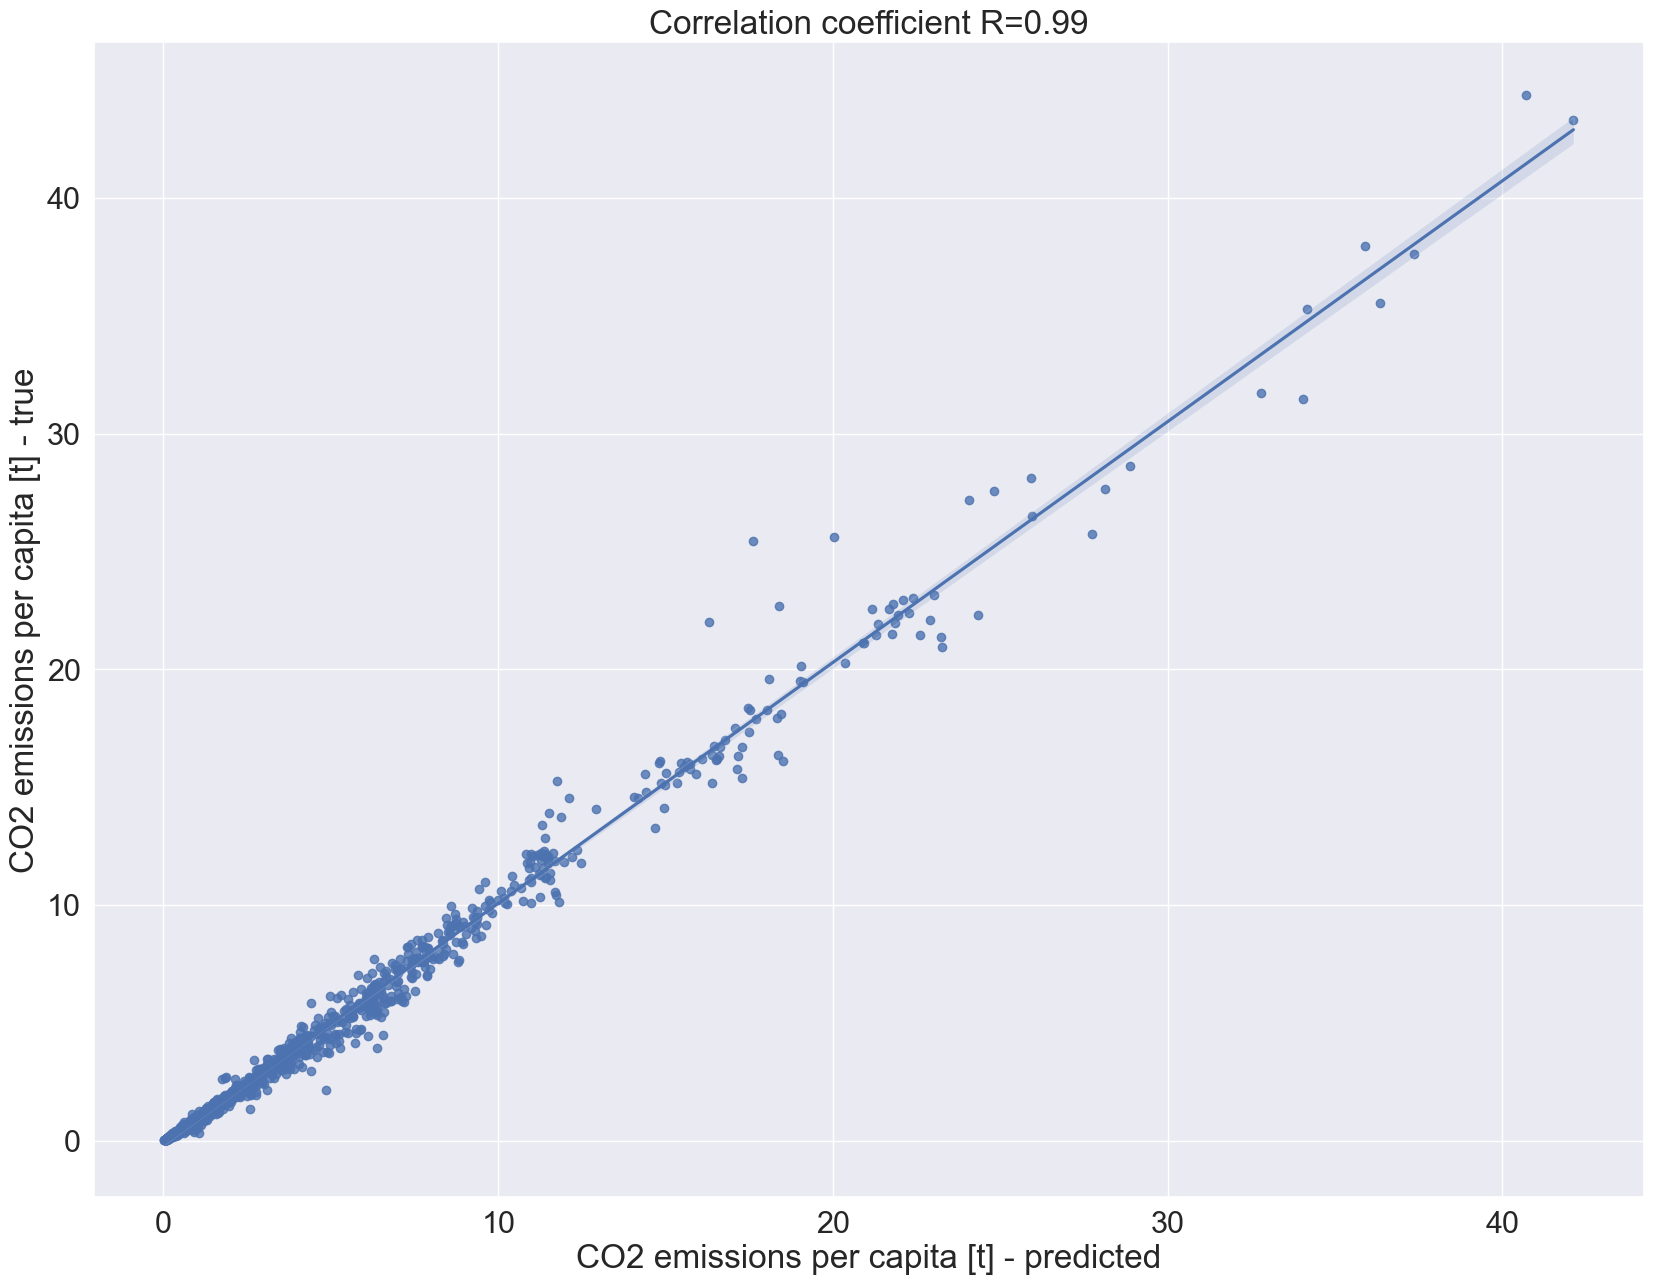

In [90]:
# Ensure y_test is a 1-dimensional array
y_test = np.array(y_test).flatten()
predictions = np.array(predictions).flatten()

# Plot predicted vs true values of the test subset
f, ax = plt.subplots(figsize=(20, 15))
sns.set(font_scale=2)

sns.regplot(x=predictions, y=y_test, fit_reg=True)
plt.xlabel("CO2 emissions per capita [t] - predicted")
plt.ylabel("CO2 emissions per capita [t] - true")
plt.title("Correlation coefficient R=" + str(round(np.corrcoef(predictions, y_test)[0, 1], 2)))
plt.show()

The predictions of the CO2 emissions correlate very well with their true values and their vast majority is observed on the regression line or in its immediate vicinity.